In [1]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    Dropout
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay,classification_report,precision_score,recall_score,f1_score
import time
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import pickle
from IPython.display import display

In [3]:
def matrix_confusion(yt, yp,time_taken):
    data = {'Y_Real': yt,
            'Y_Pred': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Pred'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Pred'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()
    y_val = df['Y_Real'].to_numpy()
    predictions = df['Y_Pred'].to_numpy()
    accuracy = accuracy_score(y_val,predictions)
    precision = precision_score(y_val,predictions)
    recall = recall_score(y_val,predictions)
    f1 = f1_score(y_val,predictions)
    print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Total Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    print("Classification Report:\n")
    print(classification_report(y_val,predictions))


    return time_taken,accuracy,precision,recall,f1

In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [6]:
train_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/train', transform=transform)
test_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/test', transform=transform)
valid_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/valid', transform=transform)

In [7]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [8]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=8)
test_loader = DataLoader(valid_data, shuffle=True, batch_size=1)
hold_out_test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [9]:
# Normal (0) and True, Pneumonia (1)
print((train_loader.dataset.class_to_idx))
print((test_loader.dataset.class_to_idx))
print((hold_out_test_loader.dataset.class_to_idx))

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


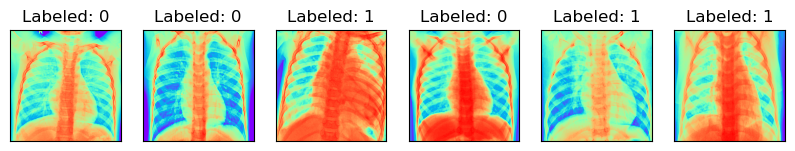

In [10]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [11]:
num_epochs_list = [4,8,16]
learning_rates = [0.0001,0.001, 0.01]
optimizers = ['SGD','Adam']

In [12]:
import warnings
warnings.filterwarnings("ignore")

Epochs: 4, learning rate: 0.0001, optimizer: SGD
Current: 1/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 67.231
Training [25%]	Loss: 0.6170	Accuracy: 67.23%
Saving model with test loss of 75.129
Training [50%]	Loss: 0.5104	Accuracy: 75.13%
Saving model with test loss of 78.538
Training [75%]	Loss: 0.4439	Accuracy: 78.54%
Saving model with test loss of 81.923
Training [100%]	Loss: 0.4038	Accuracy: 81.92%


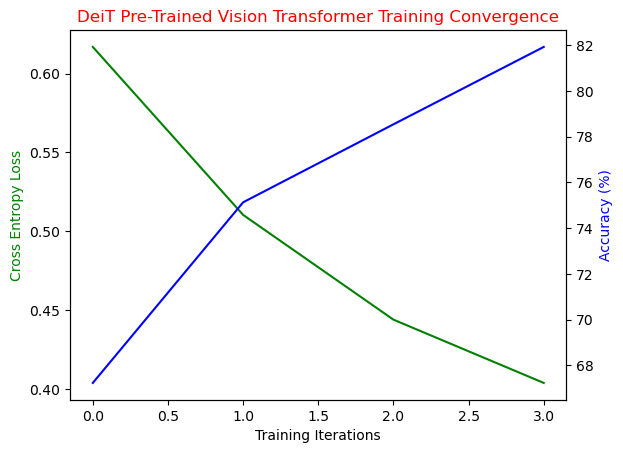

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.3803
	Accuracy: 84.21%
[1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,

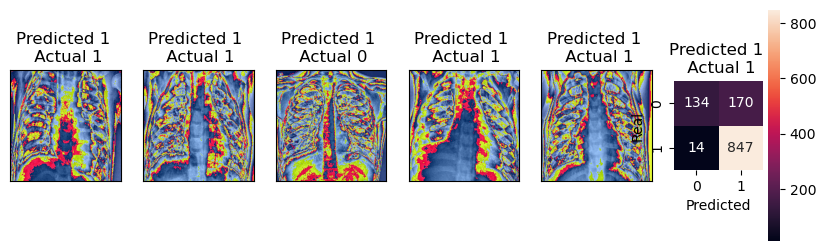

Time taken:  147.53396797180176
Test size: 1165
Total Accuracy:  0.8420600858369098
Total Precision:  0.8328416912487709
Total Recall:  0.983739837398374
Total F1 Score:  0.9020234291799788
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       304
           1       0.83      0.98      0.90       861

    accuracy                           0.84      1165
   macro avg       0.87      0.71      0.75      1165
weighted avg       0.85      0.84      0.82      1165



Time  Accuracy  Precision  \
DieT Model_epochs4_lr0.0001_optimizerSGD  147.533968   0.84206   0.832842   

                                           Recall  F1 score  
DieT Model_epochs4_lr0.0001_optimizerSGD  0.98374  0.902023

Data Stored Successfully
Epochs: 4, learning rate: 0.0001, optimizer: Adam
Current: 2/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 89.723
Training [25%]	Loss: 0.2602	Accuracy: 89.72%
Saving model with test loss of 93.010
Training [50%]	Loss: 0.1852	Accuracy: 93.01%
Saving model with test loss of 93.794
Training [75%]	Loss: 0.1646	Accuracy: 93.79%
Saving model with test loss of 94.334
Training [100%]	Loss: 0.1527	Accuracy: 94.33%


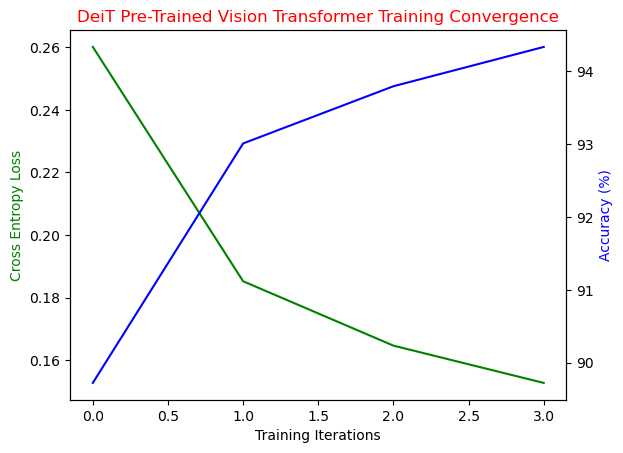

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1720
	Accuracy: 92.88%
[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,

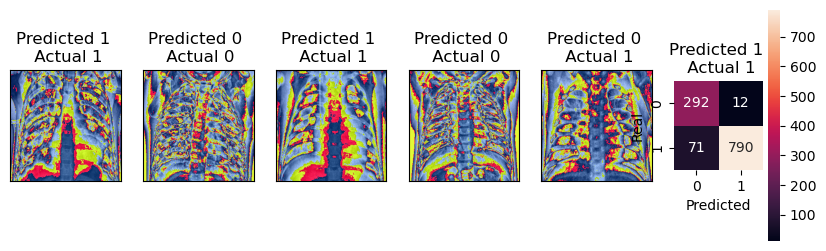

Time taken:  146.34672713279724
Test size: 1165
Total Accuracy:  0.9287553648068669
Total Precision:  0.9850374064837906
Total Recall:  0.9175377468060395
Total F1 Score:  0.9500901984365604
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.96      0.88       304
           1       0.99      0.92      0.95       861

    accuracy                           0.93      1165
   macro avg       0.89      0.94      0.91      1165
weighted avg       0.94      0.93      0.93      1165



Time  Accuracy  Precision  \
DieT Model_epochs4_lr0.0001_optimizerAdam  146.346727  0.928755   0.985037   

                                             Recall  F1 score  
DieT Model_epochs4_lr0.0001_optimizerAdam  0.917538   0.95009

Data Stored Successfully
Epochs: 4, learning rate: 0.001, optimizer: SGD
Current: 3/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 83.125
Training [25%]	Loss: 0.3754	Accuracy: 83.12%
Saving model with test loss of 89.772
Training [50%]	Loss: 0.2551	Accuracy: 89.77%
Saving model with test loss of 91.366
Training [75%]	Loss: 0.2231	Accuracy: 91.37%
Saving model with test loss of 92.004
Training [100%]	Loss: 0.2073	Accuracy: 92.00%


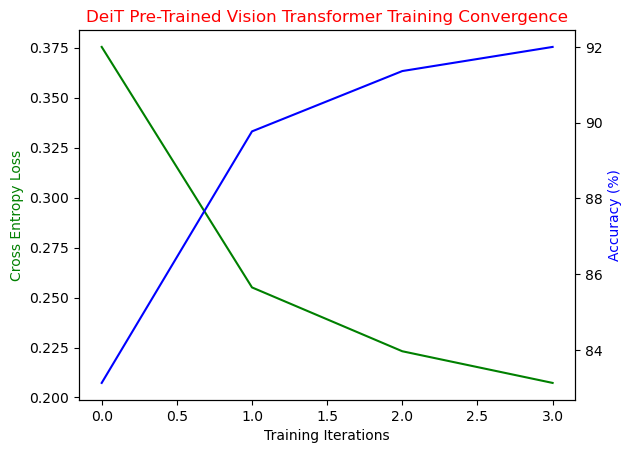

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1913
	Accuracy: 91.67%
[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,

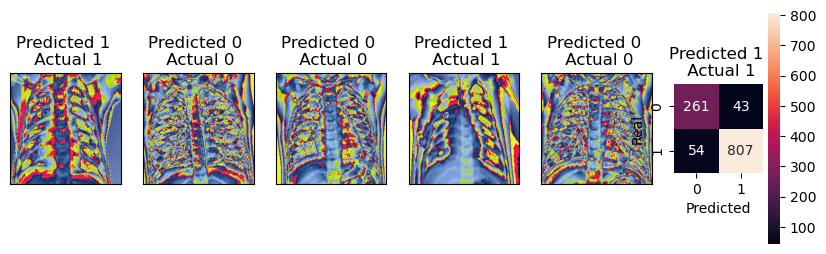

Time taken:  145.3124485015869
Test size: 1165
Total Accuracy:  0.9167381974248927
Total Precision:  0.9494117647058824
Total Recall:  0.9372822299651568
Total F1 Score:  0.9433080070134424
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       304
           1       0.95      0.94      0.94       861

    accuracy                           0.92      1165
   macro avg       0.89      0.90      0.89      1165
weighted avg       0.92      0.92      0.92      1165



Time  Accuracy  Precision  \
DieT Model_epochs4_lr0.001_optimizerSGD  145.312449  0.916738   0.949412   

                                           Recall  F1 score  
DieT Model_epochs4_lr0.001_optimizerSGD  0.937282  0.943308

Data Stored Successfully
Epochs: 4, learning rate: 0.001, optimizer: Adam
Current: 4/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 91.293
Training [25%]	Loss: 0.2286	Accuracy: 91.29%
Saving model with test loss of 93.721
Training [50%]	Loss: 0.1744	Accuracy: 93.72%
Saving model with test loss of 93.770
Training [75%]	Loss: 0.1615	Accuracy: 93.77%
Saving model with test loss of 94.555
Training [100%]	Loss: 0.1499	Accuracy: 94.55%


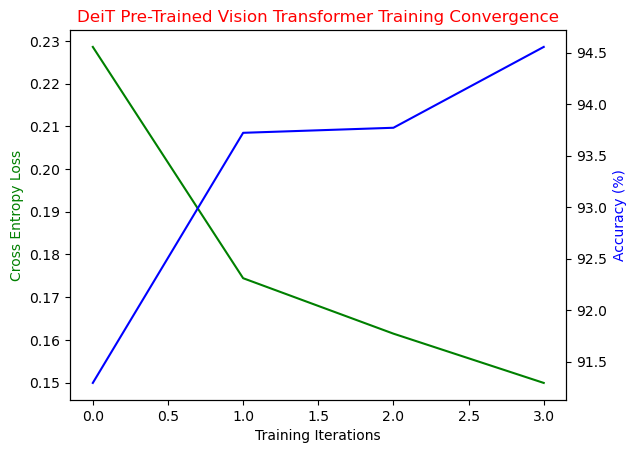

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1517
	Accuracy: 93.82%
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

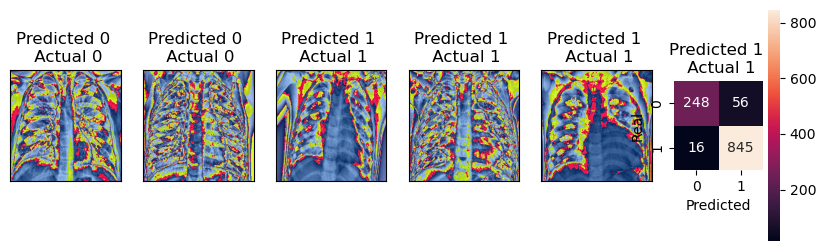

Time taken:  147.46227765083313
Test size: 1165
Total Accuracy:  0.9381974248927039
Total Precision:  0.9378468368479467
Total Recall:  0.9814169570267132
Total F1 Score:  0.9591373439273553
Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       304
           1       0.94      0.98      0.96       861

    accuracy                           0.94      1165
   macro avg       0.94      0.90      0.92      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  Precision  \
DieT Model_epochs4_lr0.001_optimizerAdam  147.462278  0.938197   0.937847   

                                            Recall  F1 score  
DieT Model_epochs4_lr0.001_optimizerAdam  0.981417  0.959137

Data Stored Successfully
Epochs: 4, learning rate: 0.01, optimizer: SGD
Current: 5/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 90.091
Training [25%]	Loss: 0.2427	Accuracy: 90.09%
Saving model with test loss of 92.961
Training [50%]	Loss: 0.1823	Accuracy: 92.96%
Saving model with test loss of 93.598
Training [75%]	Loss: 0.1680	Accuracy: 93.60%
Saving model with test loss of 94.383
Training [100%]	Loss: 0.1541	Accuracy: 94.38%


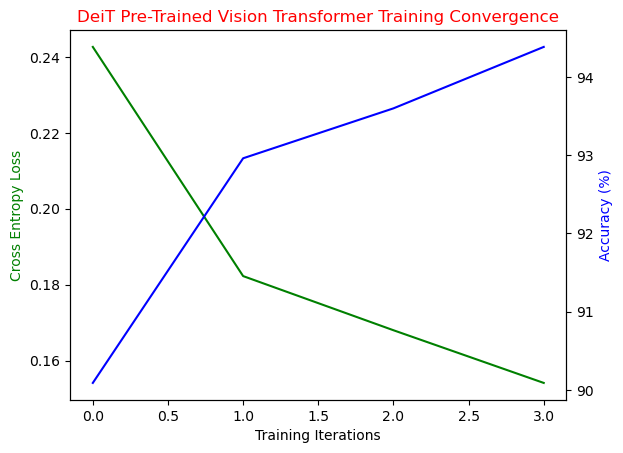

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1415
	Accuracy: 94.68%
[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,

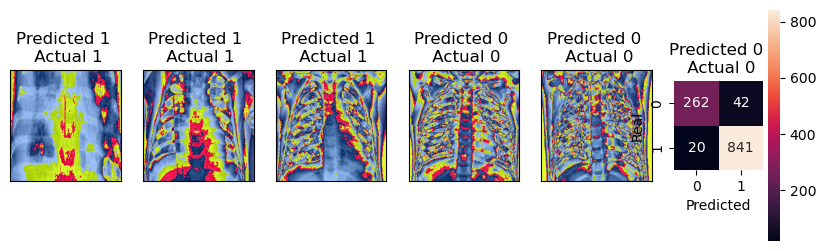

Time taken:  145.0452663898468
Test size: 1165
Total Accuracy:  0.9467811158798283
Total Precision:  0.9524348810872028
Total Recall:  0.9767711962833914
Total F1 Score:  0.9644495412844036
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       304
           1       0.95      0.98      0.96       861

    accuracy                           0.95      1165
   macro avg       0.94      0.92      0.93      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  Precision  \
DieT Model_epochs4_lr0.01_optimizerSGD  145.045266  0.946781   0.952435   

                                          Recall  F1 score  
DieT Model_epochs4_lr0.01_optimizerSGD  0.976771   0.96445

Data Stored Successfully
Epochs: 4, learning rate: 0.01, optimizer: Adam
Current: 6/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 88.717
Training [25%]	Loss: 0.3263	Accuracy: 88.72%
Saving model with test loss of 90.778
Training [50%]	Loss: 0.2576	Accuracy: 90.78%
Saving model with test loss of 90.238
Training [75%]	Loss: 0.2469	Accuracy: 90.24%
Saving model with test loss of 90.140
Training [100%]	Loss: 0.2390	Accuracy: 90.14%


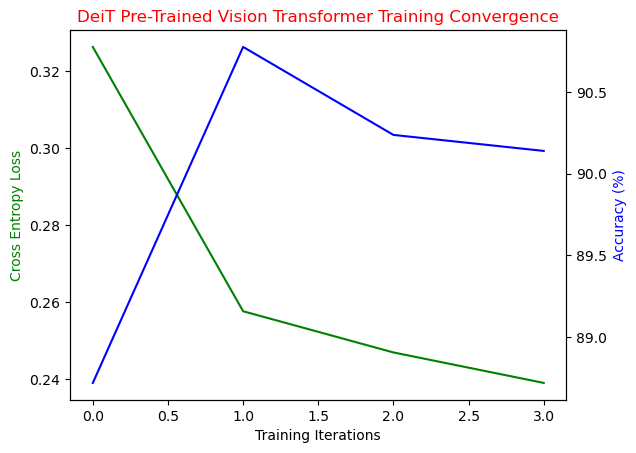

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.2565
	Accuracy: 87.90%
[1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,

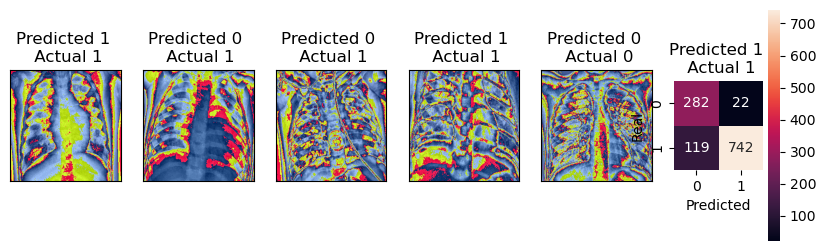

Time taken:  146.49418783187866
Test size: 1165
Total Accuracy:  0.878969957081545
Total Precision:  0.9712041884816754
Total Recall:  0.8617886178861789
Total F1 Score:  0.9132307692307694
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       304
           1       0.97      0.86      0.91       861

    accuracy                           0.88      1165
   macro avg       0.84      0.89      0.86      1165
weighted avg       0.90      0.88      0.88      1165



Time  Accuracy  Precision  \
DieT Model_epochs4_lr0.01_optimizerAdam  146.494188   0.87897   0.971204   

                                           Recall  F1 score  
DieT Model_epochs4_lr0.01_optimizerAdam  0.861789  0.913231

Data Stored Successfully
Epochs: 8, learning rate: 0.0001, optimizer: SGD
Current: 7/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 72.504
Training [12%]	Loss: 0.5503	Accuracy: 72.50%
Saving model with test loss of 76.674
Training [25%]	Loss: 0.4747	Accuracy: 76.67%
Saving model with test loss of 80.819
Training [38%]	Loss: 0.4180	Accuracy: 80.82%
Saving model with test loss of 83.027
Training [50%]	Loss: 0.3850	Accuracy: 83.03%
Saving model with test loss of 85.504
Training [62%]	Loss: 0.3560	Accuracy: 85.50%
Saving model with test loss of 86.755
Training [75%]	Loss: 0.3325	Accuracy: 86.75%
Saving model with test loss of 87.810
Training [88%]	Loss: 0.3140	Accuracy: 87.81%
Saving model with test loss of 88.472
Training [100%]	Loss: 0.2997	Accuracy: 88.47%


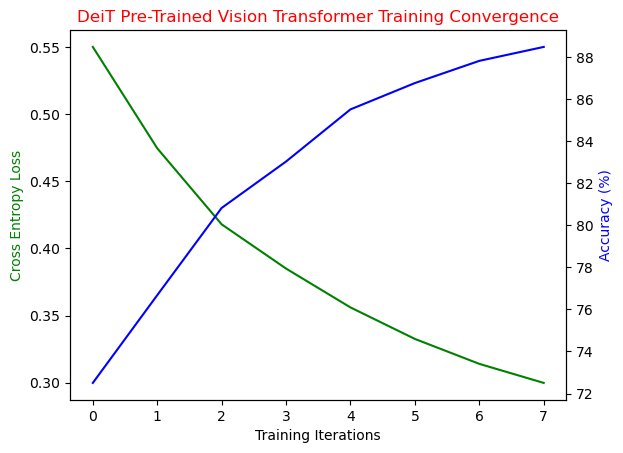

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.2852
	Accuracy: 88.93%
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

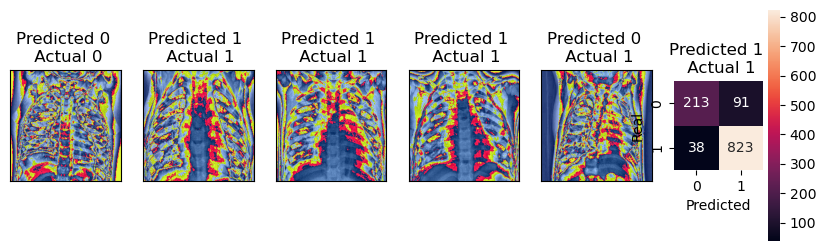

Time taken:  289.9622554779053
Test size: 1165
Total Accuracy:  0.8892703862660944
Total Precision:  0.9004376367614879
Total Recall:  0.9558652729384437
Total F1 Score:  0.9273239436619718
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       304
           1       0.90      0.96      0.93       861

    accuracy                           0.89      1165
   macro avg       0.87      0.83      0.85      1165
weighted avg       0.89      0.89      0.89      1165



Time  Accuracy  Precision  \
DieT Model_epochs8_lr0.0001_optimizerSGD  289.962255   0.88927   0.900438   

                                            Recall  F1 score  
DieT Model_epochs8_lr0.0001_optimizerSGD  0.955865  0.927324

Data Stored Successfully
Epochs: 8, learning rate: 0.0001, optimizer: Adam
Current: 8/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 89.306
Training [12%]	Loss: 0.2719	Accuracy: 89.31%
Saving model with test loss of 93.059
Training [25%]	Loss: 0.1814	Accuracy: 93.06%
Saving model with test loss of 93.844
Training [38%]	Loss: 0.1654	Accuracy: 93.84%
Saving model with test loss of 94.628
Training [50%]	Loss: 0.1519	Accuracy: 94.63%
Saving model with test loss of 94.457
Training [62%]	Loss: 0.1464	Accuracy: 94.46%
Saving model with test loss of 95.070
Training [75%]	Loss: 0.1409	Accuracy: 95.07%
Saving model with test loss of 95.291
Training [88%]	Loss: 0.1303	Accuracy: 95.29%
Saving model with test loss of 95.364
Training [100%]	Loss: 0.1280	Accuracy: 95.36%


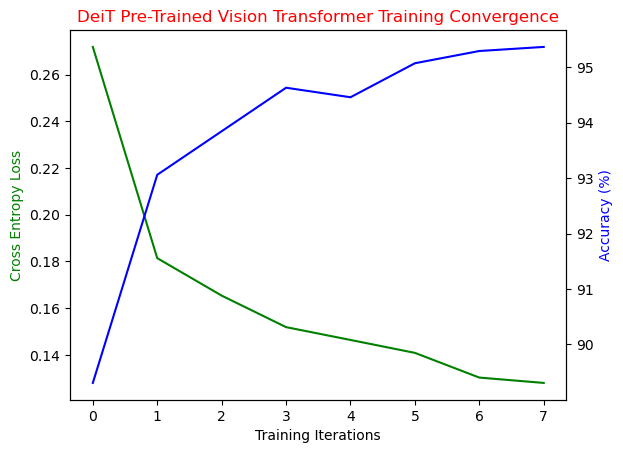

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1260
	Accuracy: 95.19%
[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,

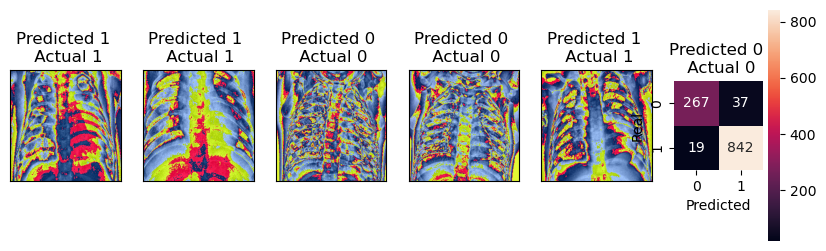

Time taken:  290.66077303886414
Test size: 1165
Total Accuracy:  0.951931330472103
Total Precision:  0.9579067121729238
Total Recall:  0.9779326364692218
Total F1 Score:  0.9678160919540231
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       304
           1       0.96      0.98      0.97       861

    accuracy                           0.95      1165
   macro avg       0.95      0.93      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  Precision  \
DieT Model_epochs8_lr0.0001_optimizerAdam  290.660773  0.951931   0.957907   

                                             Recall  F1 score  
DieT Model_epochs8_lr0.0001_optimizerAdam  0.977933  0.967816

Data Stored Successfully
Epochs: 8, learning rate: 0.001, optimizer: SGD
Current: 9/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 84.768
Training [12%]	Loss: 0.3683	Accuracy: 84.77%
Saving model with test loss of 89.772
Training [25%]	Loss: 0.2530	Accuracy: 89.77%
Saving model with test loss of 91.685
Training [38%]	Loss: 0.2253	Accuracy: 91.69%
Saving model with test loss of 91.979
Training [50%]	Loss: 0.2086	Accuracy: 91.98%
Saving model with test loss of 92.593
Training [62%]	Loss: 0.1965	Accuracy: 92.59%
Saving model with test loss of 92.544
Training [75%]	Loss: 0.1884	Accuracy: 92.54%
Saving model with test loss of 92.666
Training [88%]	Loss: 0.1845	Accuracy: 92.67%
Saving model with test loss of 93.083
Training [100%]	Loss: 0.1771	Accuracy: 93.08%


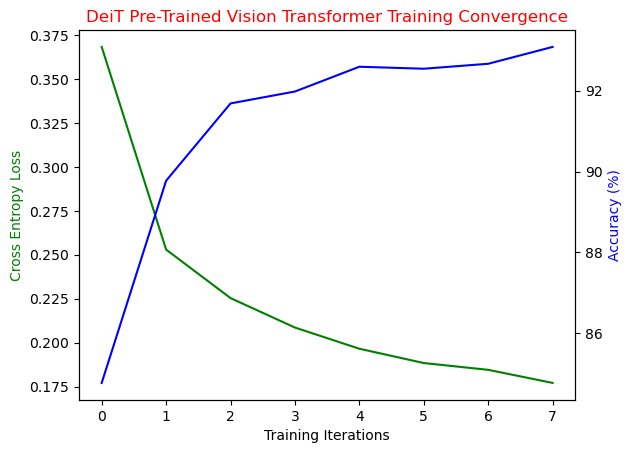

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1725
	Accuracy: 92.88%
[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,

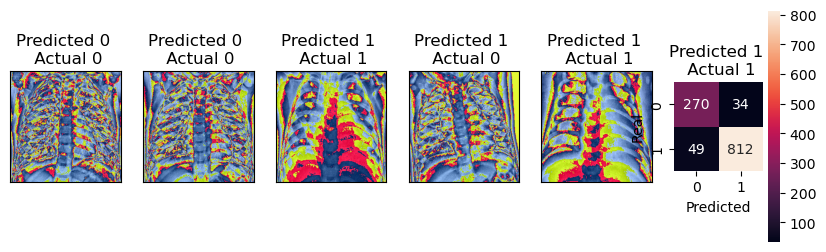

Time taken:  290.9169623851776
Test size: 1165
Total Accuracy:  0.9287553648068669
Total Precision:  0.9598108747044918
Total Recall:  0.943089430894309
Total F1 Score:  0.9513766842413591
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       304
           1       0.96      0.94      0.95       861

    accuracy                           0.93      1165
   macro avg       0.90      0.92      0.91      1165
weighted avg       0.93      0.93      0.93      1165



Time  Accuracy  Precision  \
DieT Model_epochs8_lr0.001_optimizerSGD  290.916962  0.928755   0.959811   

                                           Recall  F1 score  
DieT Model_epochs8_lr0.001_optimizerSGD  0.943089  0.951377

Data Stored Successfully
Epochs: 8, learning rate: 0.001, optimizer: Adam
Current: 10/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 90.459
Training [12%]	Loss: 0.2283	Accuracy: 90.46%
Saving model with test loss of 93.574
Training [25%]	Loss: 0.1746	Accuracy: 93.57%
Saving model with test loss of 93.819
Training [38%]	Loss: 0.1626	Accuracy: 93.82%
Saving model with test loss of 94.481
Training [50%]	Loss: 0.1509	Accuracy: 94.48%
Saving model with test loss of 94.383
Training [62%]	Loss: 0.1468	Accuracy: 94.38%
Saving model with test loss of 94.923
Training [75%]	Loss: 0.1408	Accuracy: 94.92%
Saving model with test loss of 95.193
Training [88%]	Loss: 0.1337	Accuracy: 95.19%
Saving model with test loss of 95.340
Training [100%]	Loss: 0.1263	Accuracy: 95.34%


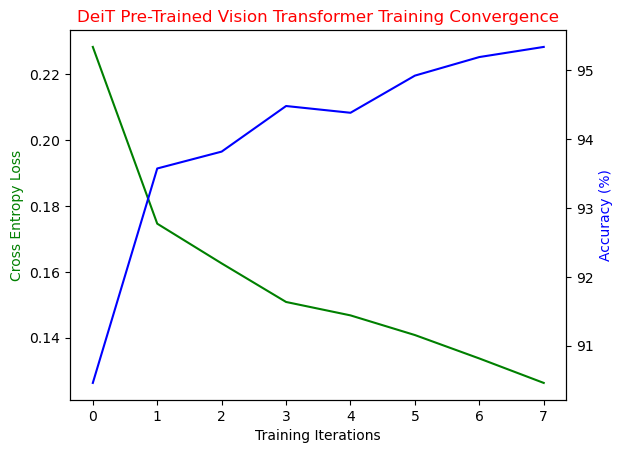

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1227
	Accuracy: 95.19%
[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

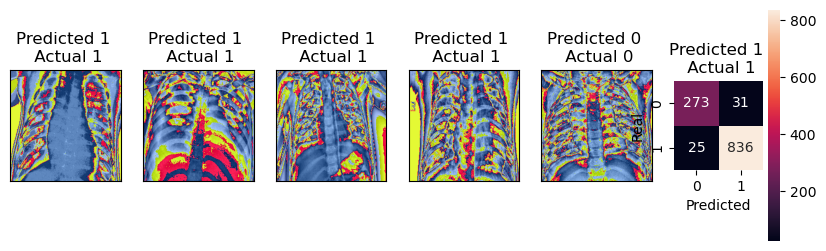

Time taken:  292.3341233730316
Test size: 1165
Total Accuracy:  0.951931330472103
Total Precision:  0.9642445213379469
Total Recall:  0.9709639953542393
Total F1 Score:  0.9675925925925927
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       304
           1       0.96      0.97      0.97       861

    accuracy                           0.95      1165
   macro avg       0.94      0.93      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  Precision  \
DieT Model_epochs8_lr0.001_optimizerAdam  292.334123  0.951931   0.964245   

                                            Recall  F1 score  
DieT Model_epochs8_lr0.001_optimizerAdam  0.970964  0.967593

Data Stored Successfully
Epochs: 8, learning rate: 0.01, optimizer: SGD
Current: 11/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 89.723
Training [12%]	Loss: 0.2463	Accuracy: 89.72%
Saving model with test loss of 93.181
Training [25%]	Loss: 0.1855	Accuracy: 93.18%
Saving model with test loss of 93.549
Training [38%]	Loss: 0.1715	Accuracy: 93.55%
Saving model with test loss of 94.187
Training [50%]	Loss: 0.1518	Accuracy: 94.19%
Saving model with test loss of 94.604
Training [62%]	Loss: 0.1448	Accuracy: 94.60%
Saving model with test loss of 94.653
Training [75%]	Loss: 0.1434	Accuracy: 94.65%
Saving model with test loss of 95.168
Training [88%]	Loss: 0.1374	Accuracy: 95.17%
Saving model with test loss of 95.168
Training [100%]	Loss: 0.1294	Accuracy: 95.17%


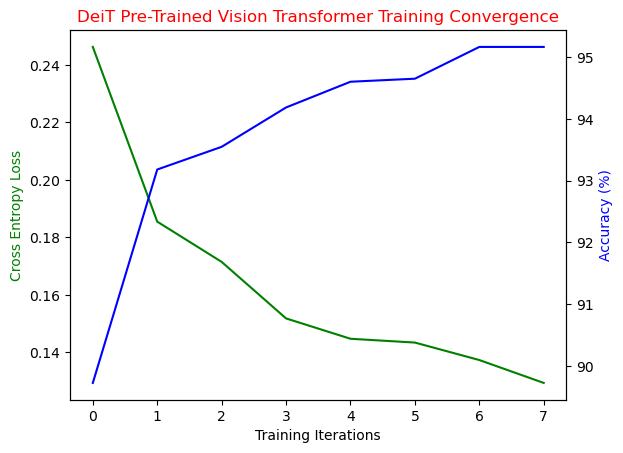

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1292
	Accuracy: 95.28%
[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,

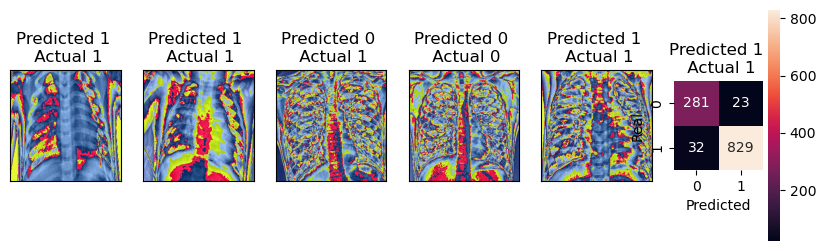

Time taken:  289.9465651512146
Test size: 1165
Total Accuracy:  0.9527896995708155
Total Precision:  0.9730046948356808
Total Recall:  0.9628339140534262
Total F1 Score:  0.9678925861062463
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       304
           1       0.97      0.96      0.97       861

    accuracy                           0.95      1165
   macro avg       0.94      0.94      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  Precision  \
DieT Model_epochs8_lr0.01_optimizerSGD  289.946565   0.95279   0.973005   

                                          Recall  F1 score  
DieT Model_epochs8_lr0.01_optimizerSGD  0.962834  0.967893

Data Stored Successfully
Epochs: 8, learning rate: 0.01, optimizer: Adam
Current: 12/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Saving model with test loss of 89.723
Training [12%]	Loss: 0.3208	Accuracy: 89.72%
Saving model with test loss of 91.587
Training [25%]	Loss: 0.2321	Accuracy: 91.59%
Saving model with test loss of 90.753
Training [38%]	Loss: 0.2297	Accuracy: 90.75%
Saving model with test loss of 91.440
Training [50%]	Loss: 0.2223	Accuracy: 91.44%
Saving model with test loss of 90.679
Training [62%]	Loss: 0.2205	Accuracy: 90.68%
Saving model with test loss of 91.513
Training [75%]	Loss: 0.2183	Accuracy: 91.51%
Saving model with test loss of 92.323
Training [88%]	Loss: 0.1913	Accuracy: 92.32%
Saving model with test loss of 92.274
Training [100%]	Loss: 0.1985	Accuracy: 92.27%


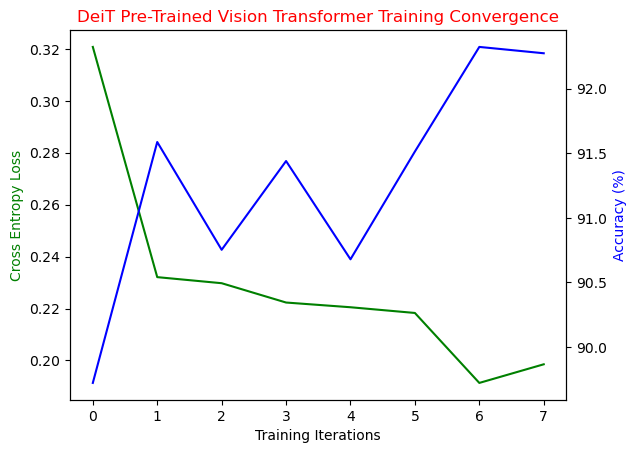

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1773
	Accuracy: 93.73%
[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,

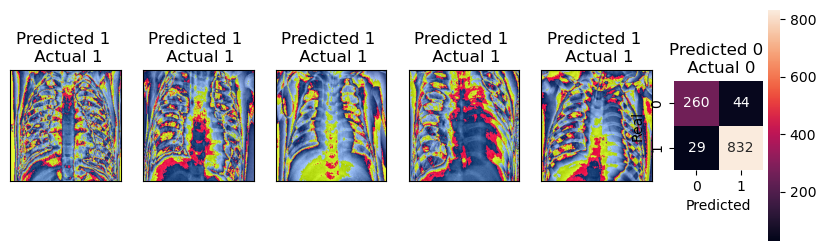

Time taken:  293.2383997440338
Test size: 1165
Total Accuracy:  0.9373390557939915
Total Precision:  0.9497716894977168
Total Recall:  0.9663182346109176
Total F1 Score:  0.9579735175590098
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       304
           1       0.95      0.97      0.96       861

    accuracy                           0.94      1165
   macro avg       0.92      0.91      0.92      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  Precision  \
DieT Model_epochs8_lr0.01_optimizerAdam  293.2384  0.937339   0.949772   

                                           Recall  F1 score  
DieT Model_epochs8_lr0.01_optimizerAdam  0.966318  0.957974

Data Stored Successfully
Epochs: 16, learning rate: 0.0001, optimizer: SGD
Current: 13/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.5294	Accuracy: 73.31%
Saving model with test loss of 79.225
Training [12%]	Loss: 0.4500	Accuracy: 79.22%
Training [19%]	Loss: 0.3993	Accuracy: 82.66%
Saving model with test loss of 85.161
Training [25%]	Loss: 0.3662	Accuracy: 85.16%
Saving model with test loss of 86.289
Training [31%]	Loss: 0.3425	Accuracy: 86.29%
Training [38%]	Loss: 0.3215	Accuracy: 87.17%
Saving model with test loss of 88.374
Training [44%]	Loss: 0.3076	Accuracy: 88.37%
Saving model with test loss of 88.595
Training [50%]	Loss: 0.2937	Accuracy: 88.59%
Training [56%]	Loss: 0.2830	Accuracy: 88.91%
Saving model with test loss of 89.919
Training [62%]	Loss: 0.2762	Accuracy: 89.92%
Training [69%]	Loss: 0.2699	Accuracy: 88.86%
Saving model with test loss of 89.404
Training [75%]	Loss: 0.2660	Accuracy: 89.40%
Saving model with test loss of 90.042
Training [81%]	Loss: 0.2555	Accuracy: 90.04%
Training [88%]	Loss: 0.2578	Accuracy: 89.38%
Saving model with test loss of 90.385
Training [94%]	Loss: 0.2453	A

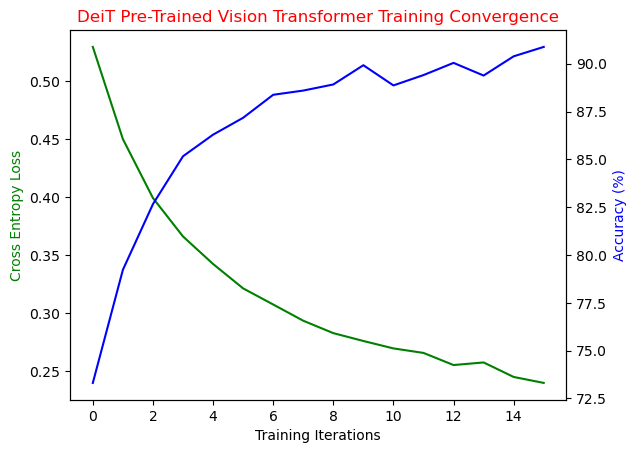

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.2312
	Accuracy: 90.56%
[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,

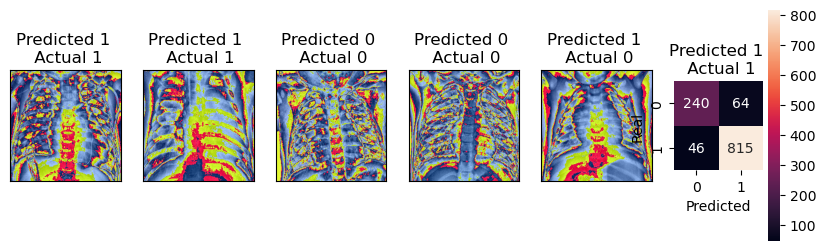

Time taken:  580.5000851154327
Test size: 1165
Total Accuracy:  0.9055793991416309
Total Precision:  0.9271899886234357
Total Recall:  0.9465737514518002
Total F1 Score:  0.9367816091954022
Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       304
           1       0.93      0.95      0.94       861

    accuracy                           0.91      1165
   macro avg       0.88      0.87      0.88      1165
weighted avg       0.90      0.91      0.90      1165



Time  Accuracy  Precision  \
DieT Model_epochs16_lr0.0001_optimizerSGD  580.500085  0.905579    0.92719   

                                             Recall  F1 score  
DieT Model_epochs16_lr0.0001_optimizerSGD  0.946574  0.936782

Data Stored Successfully
Epochs: 16, learning rate: 0.0001, optimizer: Adam
Current: 14/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.2638	Accuracy: 89.33%
Saving model with test loss of 92.887
Training [12%]	Loss: 0.1827	Accuracy: 92.89%
Training [19%]	Loss: 0.1652	Accuracy: 93.77%
Saving model with test loss of 94.285
Training [25%]	Loss: 0.1524	Accuracy: 94.29%
Saving model with test loss of 94.972
Training [31%]	Loss: 0.1472	Accuracy: 94.97%
Training [38%]	Loss: 0.1424	Accuracy: 94.63%
Saving model with test loss of 94.996
Training [44%]	Loss: 0.1376	Accuracy: 95.00%
Saving model with test loss of 95.315
Training [50%]	Loss: 0.1303	Accuracy: 95.32%
Training [56%]	Loss: 0.1236	Accuracy: 95.32%
Saving model with test loss of 95.659
Training [62%]	Loss: 0.1210	Accuracy: 95.66%
Training [69%]	Loss: 0.1183	Accuracy: 95.46%
Saving model with test loss of 95.928
Training [75%]	Loss: 0.1123	Accuracy: 95.93%
Saving model with test loss of 95.953
Training [81%]	Loss: 0.1068	Accuracy: 95.95%
Training [88%]	Loss: 0.1043	Accuracy: 96.32%
Saving model with test loss of 96.443
Training [94%]	Loss: 0.1009	A

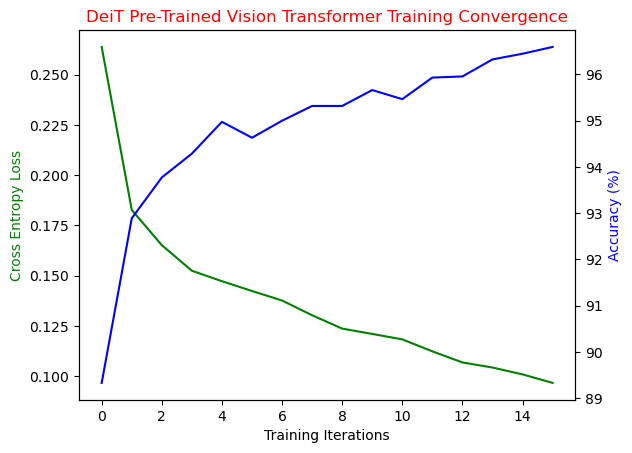

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1107
	Accuracy: 95.11%
[1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,

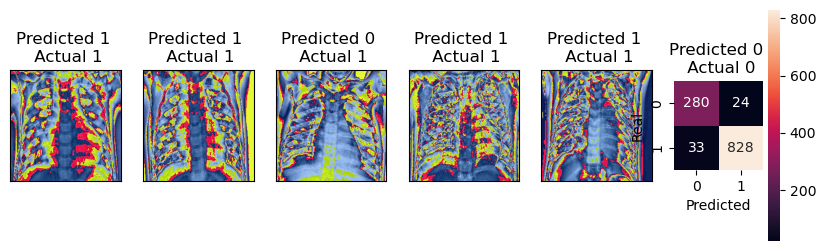

Time taken:  581.846688747406
Test size: 1165
Total Accuracy:  0.9510729613733906
Total Precision:  0.971830985915493
Total Recall:  0.9616724738675958
Total F1 Score:  0.9667250437828371
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       304
           1       0.97      0.96      0.97       861

    accuracy                           0.95      1165
   macro avg       0.93      0.94      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  Precision  \
DieT Model_epochs16_lr0.0001_optimizerAdam  581.846689  0.951073   0.971831   

                                              Recall  F1 score  
DieT Model_epochs16_lr0.0001_optimizerAdam  0.961672  0.966725

Data Stored Successfully
Epochs: 16, learning rate: 0.001, optimizer: SGD
Current: 15/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.3729	Accuracy: 84.03%
Saving model with test loss of 90.189
Training [12%]	Loss: 0.2495	Accuracy: 90.19%
Training [19%]	Loss: 0.2243	Accuracy: 91.07%
Saving model with test loss of 91.759
Training [25%]	Loss: 0.2122	Accuracy: 91.76%
Saving model with test loss of 92.200
Training [31%]	Loss: 0.1978	Accuracy: 92.20%
Training [38%]	Loss: 0.1922	Accuracy: 92.67%
Saving model with test loss of 93.157
Training [44%]	Loss: 0.1880	Accuracy: 93.16%
Saving model with test loss of 93.181
Training [50%]	Loss: 0.1764	Accuracy: 93.18%
Training [56%]	Loss: 0.1758	Accuracy: 93.23%
Saving model with test loss of 93.476
Training [62%]	Loss: 0.1731	Accuracy: 93.48%
Training [69%]	Loss: 0.1721	Accuracy: 93.57%
Saving model with test loss of 93.451
Training [75%]	Loss: 0.1676	Accuracy: 93.45%
Saving model with test loss of 94.138
Training [81%]	Loss: 0.1629	Accuracy: 94.14%
Training [88%]	Loss: 0.1656	Accuracy: 93.72%
Saving model with test loss of 94.089
Training [94%]	Loss: 0.1619	A

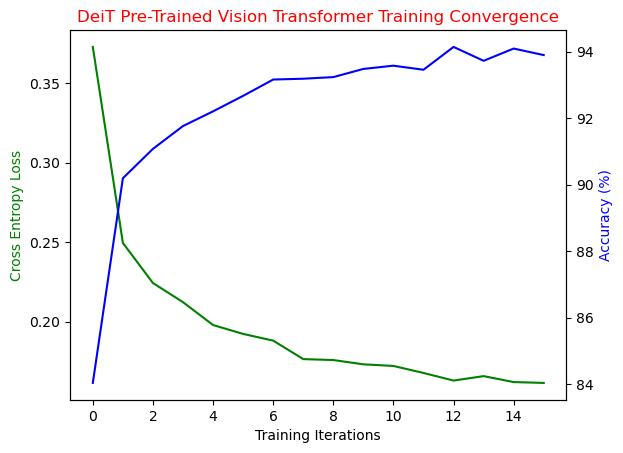

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1540
	Accuracy: 94.16%
[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,

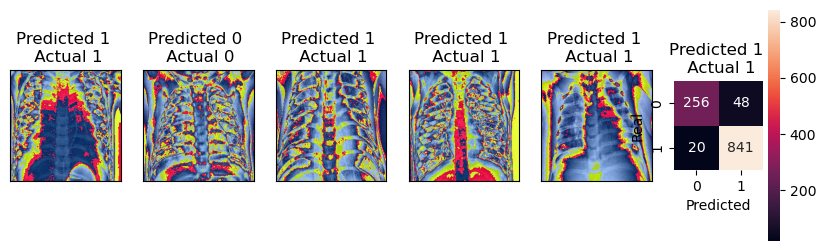

Time taken:  582.4722619056702
Test size: 1165
Total Accuracy:  0.9416309012875537
Total Precision:  0.9460067491563554
Total Recall:  0.9767711962833914
Total F1 Score:  0.9611428571428571
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       304
           1       0.95      0.98      0.96       861

    accuracy                           0.94      1165
   macro avg       0.94      0.91      0.92      1165
weighted avg       0.94      0.94      0.94      1165



Time  Accuracy  Precision  \
DieT Model_epochs16_lr0.001_optimizerSGD  582.472262  0.941631   0.946007   

                                            Recall  F1 score  
DieT Model_epochs16_lr0.001_optimizerSGD  0.976771  0.961143

Data Stored Successfully
Epochs: 16, learning rate: 0.001, optimizer: Adam
Current: 16/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.2249	Accuracy: 90.75%
Saving model with test loss of 93.059
Training [12%]	Loss: 0.1812	Accuracy: 93.06%
Training [19%]	Loss: 0.1655	Accuracy: 94.06%
Saving model with test loss of 94.015
Training [25%]	Loss: 0.1529	Accuracy: 94.02%
Saving model with test loss of 94.923
Training [31%]	Loss: 0.1429	Accuracy: 94.92%
Training [38%]	Loss: 0.1349	Accuracy: 94.95%
Saving model with test loss of 94.972
Training [44%]	Loss: 0.1309	Accuracy: 94.97%
Saving model with test loss of 95.193
Training [50%]	Loss: 0.1324	Accuracy: 95.19%
Training [56%]	Loss: 0.1228	Accuracy: 95.32%
Saving model with test loss of 95.732
Training [62%]	Loss: 0.1191	Accuracy: 95.73%
Training [69%]	Loss: 0.1132	Accuracy: 96.00%
Saving model with test loss of 96.125
Training [75%]	Loss: 0.1048	Accuracy: 96.12%
Saving model with test loss of 95.977
Training [81%]	Loss: 0.1067	Accuracy: 95.98%
Training [88%]	Loss: 0.0944	Accuracy: 96.22%
Saving model with test loss of 96.615
Training [94%]	Loss: 0.0885	A

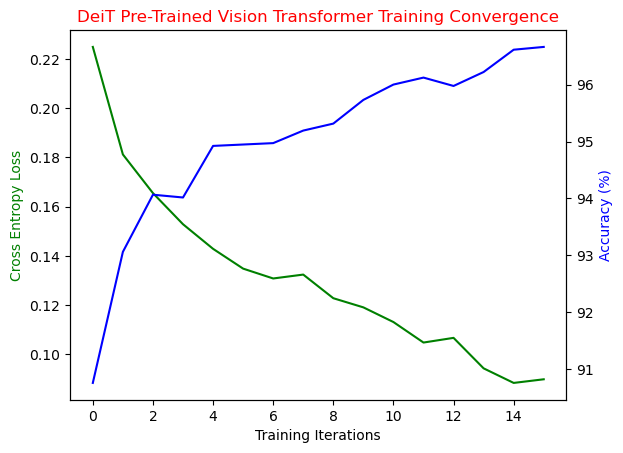

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1318
	Accuracy: 95.11%
[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,

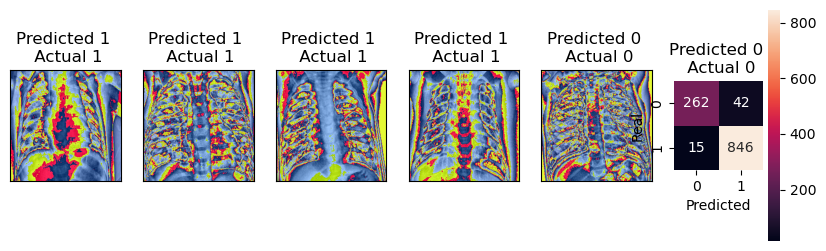

Time taken:  583.3865883350372
Test size: 1165
Total Accuracy:  0.9510729613733906
Total Precision:  0.9527027027027027
Total Recall:  0.9825783972125436
Total F1 Score:  0.9674099485420241
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       304
           1       0.95      0.98      0.97       861

    accuracy                           0.95      1165
   macro avg       0.95      0.92      0.93      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  Precision  \
DieT Model_epochs16_lr0.001_optimizerAdam  583.386588  0.951073   0.952703   

                                             Recall  F1 score  
DieT Model_epochs16_lr0.001_optimizerAdam  0.982578   0.96741

Data Stored Successfully
Epochs: 16, learning rate: 0.01, optimizer: SGD
Current: 17/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.2463	Accuracy: 89.55%
Saving model with test loss of 92.838
Training [12%]	Loss: 0.1855	Accuracy: 92.84%
Training [19%]	Loss: 0.1612	Accuracy: 94.06%
Saving model with test loss of 94.383
Training [25%]	Loss: 0.1556	Accuracy: 94.38%
Saving model with test loss of 94.359
Training [31%]	Loss: 0.1511	Accuracy: 94.36%
Training [38%]	Loss: 0.1460	Accuracy: 94.43%
Saving model with test loss of 95.193
Training [44%]	Loss: 0.1337	Accuracy: 95.19%
Saving model with test loss of 95.217
Training [50%]	Loss: 0.1300	Accuracy: 95.22%
Training [56%]	Loss: 0.1233	Accuracy: 95.17%
Saving model with test loss of 95.315
Training [62%]	Loss: 0.1217	Accuracy: 95.32%
Training [69%]	Loss: 0.1171	Accuracy: 95.29%
Saving model with test loss of 96.026
Training [75%]	Loss: 0.1105	Accuracy: 96.03%
Saving model with test loss of 95.904
Training [81%]	Loss: 0.1116	Accuracy: 95.90%
Training [88%]	Loss: 0.1043	Accuracy: 96.00%
Saving model with test loss of 96.076
Training [94%]	Loss: 0.1056	A

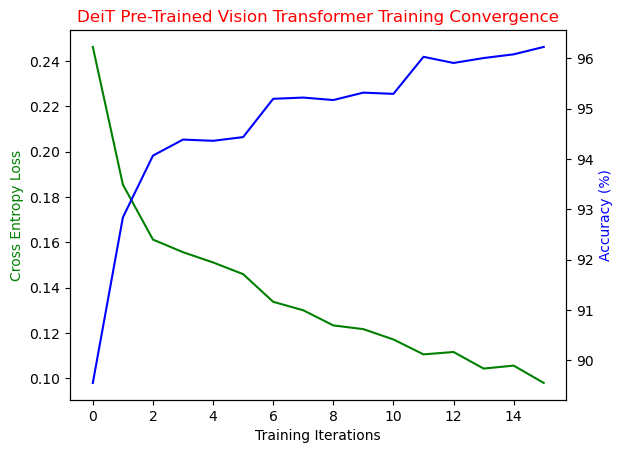

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1168
	Accuracy: 95.11%
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

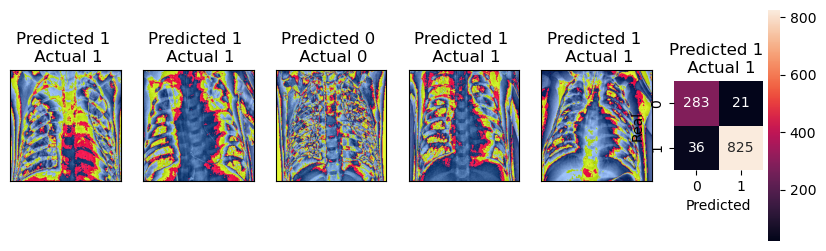

Time taken:  578.6891350746155
Test size: 1165
Total Accuracy:  0.9510729613733906
Total Precision:  0.975177304964539
Total Recall:  0.9581881533101045
Total F1 Score:  0.9666080843585237
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       304
           1       0.98      0.96      0.97       861

    accuracy                           0.95      1165
   macro avg       0.93      0.94      0.94      1165
weighted avg       0.95      0.95      0.95      1165



Time  Accuracy  Precision  \
DieT Model_epochs16_lr0.01_optimizerSGD  578.689135  0.951073   0.975177   

                                           Recall  F1 score  
DieT Model_epochs16_lr0.01_optimizerSGD  0.958188  0.966608

Data Stored Successfully
Epochs: 16, learning rate: 0.01, optimizer: Adam
Current: 18/18


Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Training [6%]	Loss: 0.3213	Accuracy: 89.01%
Saving model with test loss of 91.342
Training [12%]	Loss: 0.2503	Accuracy: 91.34%
Training [19%]	Loss: 0.2298	Accuracy: 90.85%
Saving model with test loss of 91.538
Training [25%]	Loss: 0.2227	Accuracy: 91.54%
Saving model with test loss of 91.611
Training [31%]	Loss: 0.2169	Accuracy: 91.61%
Training [38%]	Loss: 0.2212	Accuracy: 91.64%
Saving model with test loss of 91.636
Training [44%]	Loss: 0.2186	Accuracy: 91.64%
Saving model with test loss of 91.759
Training [50%]	Loss: 0.2128	Accuracy: 91.76%
Training [56%]	Loss: 0.2055	Accuracy: 92.15%
Saving model with test loss of 92.053
Training [62%]	Loss: 0.1890	Accuracy: 92.05%
Training [69%]	Loss: 0.1906	Accuracy: 92.59%
Saving model with test loss of 91.857
Training [75%]	Loss: 0.1968	Accuracy: 91.86%
Saving model with test loss of 92.200
Training [81%]	Loss: 0.1899	Accuracy: 92.20%
Training [88%]	Loss: 0.1800	Accuracy: 92.74%
Saving model with test loss of 91.464
Training [94%]	Loss: 0.1819	A

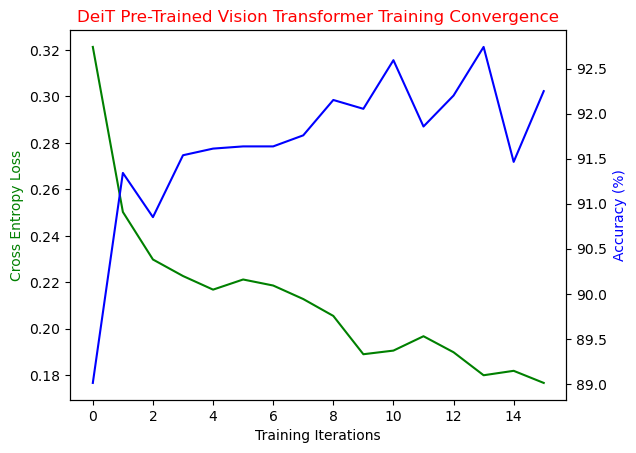

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


Performance on test data:
	Loss: 0.1607
	Accuracy: 94.51%
[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,

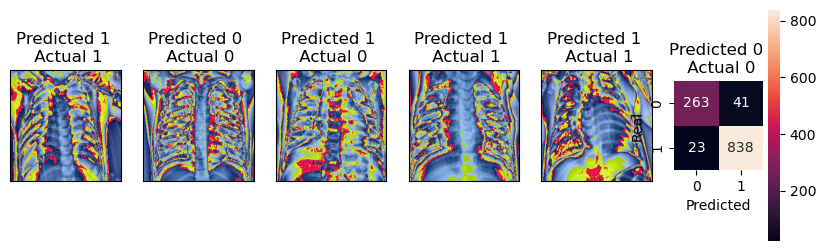

Time taken:  581.6950929164886
Test size: 1165
Total Accuracy:  0.9450643776824035
Total Precision:  0.9533560864618885
Total Recall:  0.9732868757259001
Total F1 Score:  0.9632183908045977
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       304
           1       0.95      0.97      0.96       861

    accuracy                           0.95      1165
   macro avg       0.94      0.92      0.93      1165
weighted avg       0.94      0.95      0.94      1165



Time  Accuracy  Precision  \
DieT Model_epochs16_lr0.01_optimizerAdam  581.695093  0.945064   0.953356   

                                            Recall  F1 score  
DieT Model_epochs16_lr0.01_optimizerAdam  0.973287  0.963218

Data Stored Successfully


In [13]:
number_done = 0
for epochs in num_epochs_list:
    for learning_rate in learning_rates:
        for optimizer_name in optimizers:
            print(f"Epochs: {epochs}, learning rate: {learning_rate}, optimizer: {optimizer_name}")
            number_done+=1
            print(f"Current: {number_done}/18")
            model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
            for param in model.parameters(): #freeze model
                param.requires_grad = False

            n_inputs = model.head.in_features
            model.head = Sequential(
                Linear(n_inputs, 512),
                ReLU(),
                Dropout(0.3),
                Linear(512, 2) # 2 classes
            )
            model = model.to('cuda')
            if optimizer_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(),lr=learning_rate)
            else:
                optimizer = optim.Adam(model.parameters(),lr=learning_rate)
            
            loss_func = CrossEntropyLoss().to('cuda')
            model.train()
            count = 1
            loss_list = []
            total_accuracy = []
            model_path2 = f"C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/DeitTune/DeiT model_epochs{epochs}_lr{learning_rate}_optimizer{optimizer_name}.pt"
            tic = time.time()
            for epoch in range(epochs):
                correct = 0
                total_loss = []
                batch_size = 0
                for batch_idx, (data, target) in enumerate(train_loader):
                    batch_size+=1
                    optimizer.zero_grad(set_to_none=True)
                    output = model(data.to('cuda'))  # Forward pass, Data to GPU
                    loss = loss_func(output, target.to('cuda')) #Labels to GPU
                    loss.backward()  # Backward pass
                    optimizer.step()
                    total_loss.append(loss.item())
                    train_pred = output.argmax(dim=1, keepdim=True)
                    correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
                loss_list.append(sum(total_loss) / len(total_loss))
                accuracy = 100 * correct / 4077 # No. of training examples = 4077
                total_accuracy.append(accuracy)
                if ((100*(epoch+1))//epochs)//(count*10) >0 :
                    count+=1
                    print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
                    torch.save(model.state_dict(), model_path2)
                print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


            toc = time.time()
            fig, ax1 = plt.subplots()
            ax1.plot(loss_list, 'g-')
            ax2 = ax1.twinx()
            ax2.plot(total_accuracy, 'b')
            plt.title("DeiT Pre-Trained Vision Transformer Training Convergence", color='red')
            ax1.set_xlabel("Training Iterations")
            ax1.set_ylabel("Cross Entropy Loss", color='g')
            ax2.set_ylabel("Accuracy (%)", color='b')
            plt.show()
            torch.save(model.state_dict(), model_path2)
            model_temp = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
            model_temp.head = Sequential(
                Linear(n_inputs, 512),
                ReLU(),
                Dropout(0.3),
                Linear(512, 2) # 2 classes
            )
            model_temp.load_state_dict(torch.load(model_path2))
            model_temp= model_temp.to('cuda')
            batch_size=1

            model_temp.eval()
            pred_targets = []
            test_targets= []
            with no_grad():

                correct = 0
                for batch_idx, (data, target) in enumerate(test_loader):
                    output = model_temp(data.to('cuda'))
                    if len(output.shape) == 1:
                        output = output.reshape(1, *output.shape)
                    pred = output.argmax(dim=1, keepdim=True)
                    pred_targets.append(pred.item())
                    test_targets.append(target.item())
                    correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

                    loss = loss_func(output, target.to('cuda'))
                    total_loss.append(loss.item())

                print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
                print(test_targets)
                print(pred_targets)
            from PIL import Image
            #abc
            n_samples_show = 6
            count = 0
            fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

            model_temp.eval()
            with no_grad():
                for batch_idx, (data, target) in enumerate(test_loader):
                    if count == n_samples_show:
                        break
                    output = model_temp(data.to('cuda')[0:1])
                    if len(output.shape) == 1:
                        output = output.reshape(3, *output.shape)

                    pred = output.argmax(dim=1, keepdim=True)
                    test_targets2 = target.item()
                    axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

                    axes[count].set_xticks([])
                    axes[count].set_yticks([])
                    axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

                    count += 1
            time_taken = toc-tic
            val_diet = matrix_confusion(test_targets, pred_targets,time_taken)
            name_diet = f"DieT Model_epochs{epochs}_lr{learning_rate}_optimizer{optimizer_name}"
            outdiet = pd.DataFrame([val_diet],
                            index = [name_diet],
                            columns=['Time','Accuracy','Precision','Recall','F1 score'])
            outdiet.sort_values('Time')
            display(outdiet)
            filepath1 = f"C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/DeitTune/outputdietmodel_epochs{epochs}_lr{learning_rate}_optimizer{optimizer_name}.pickle"
            with open(filepath1, 'wb') as file:
                # Serialize and write the variable to the file
                pickle.dump(outdiet, file)
                print("Data Stored Successfully")